# experimental

> Fill in a module description here

In [1]:
#| default_exp experimental

In [1]:
!which python

/home/ec2-user/anaconda3/bin/python


In [2]:
#| hide
from nbdev.showdoc import *

In [20]:
#| export
from diffusers import StableDiffusionPipeline
import torch
import tempfile
import os
import io
import base64


import pydantic


from datascience_toolkits.fastapi import create_app, serve

In [5]:
device = torch.device('cuda')
device

device(type='cuda')

In [30]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id, torch_dtype=torch.float16, revision="fp16")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [31]:
def do_nothing(clip_input, images):
    return images, [0] * len(images)

# def forward(self, clip_input, images):

In [32]:
pipe.safety_checker = do_nothing

In [33]:
pipe = pipe.to(device)

In [26]:
pipe.safety_checker.__annotations__

{'dump_patches': bool,
 '_version': int,
 'training': bool,
 '_is_full_backward_hook': typing.Union[bool, NoneType],
 'forward': typing.Callable[..., typing.Any],
 '__call__': typing.Callable[..., typing.Any]}

In [34]:
_ = pipe("", num_inference_steps=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [49]:
prompts = [
    "a photo of an astronaut riding a horse on mars",
    "test",
]
negative_promps

pipe_out = pipe(prompts, num_images_per_prompt=1)

  0%|          | 0/51 [00:00<?, ?it/s]

In [50]:
pipe_out.images

[<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>]

In [56]:
import PIL

In [57]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

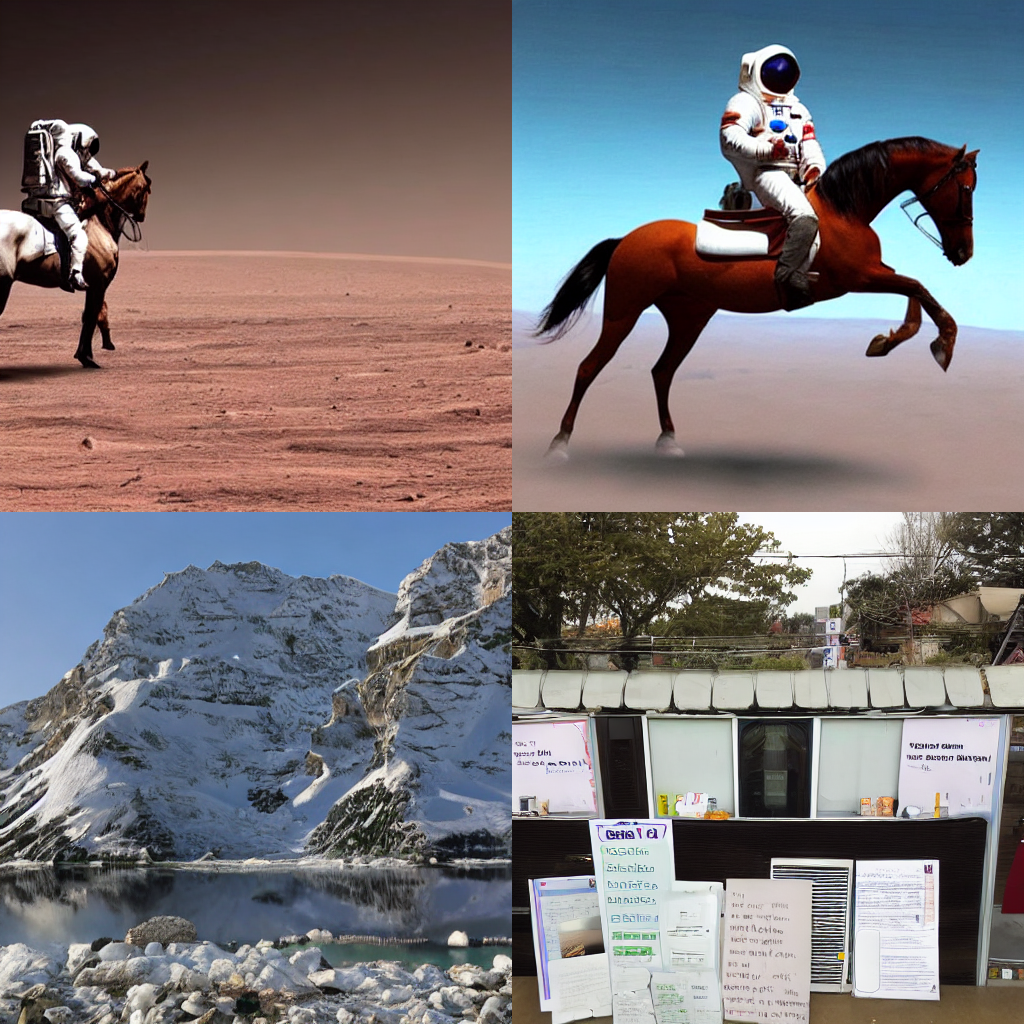

In [65]:
images = pipe_out.images
image_grid(images, 2, 2)

In [38]:
prompt = """
cyberpunk,sci-fi, fantasy,Kodak Portra 400, 8K, soft light, volumetric lighting, highly detailed, britt marling style 3/4 ,portrait photo of a beautiful cyborg woman in lingerie lying on her bed + face, intricate, elegant, highly detailed, digital painting, artstation, concept art, smooth, sharp focus
""".strip()

In [46]:
torch.manual_seed(9527)
pipe_out = pipe(prompt, num_images_per_prompt=2, num_inference_steps=10)

  0%|          | 0/11 [00:00<?, ?it/s]

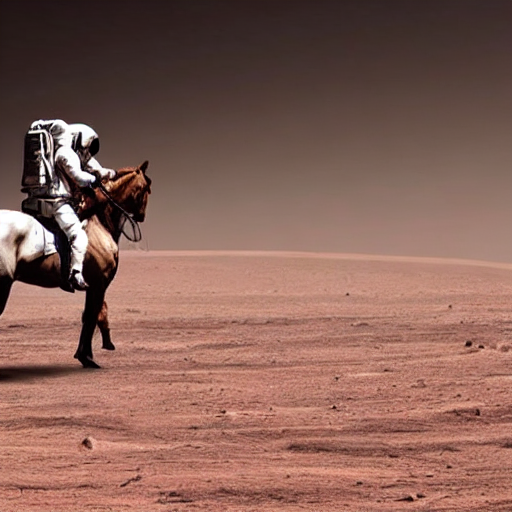

In [63]:
pipe_out.images[0]

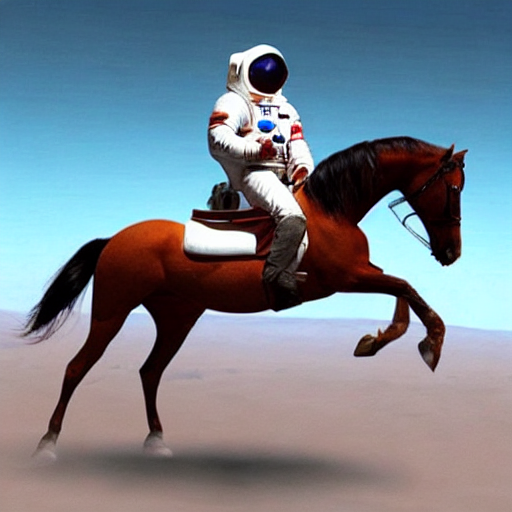

In [64]:
pipe_out.images[1]

In [72]:
init_image = images[2]
init_image.convert("RGB")
type(init_image)

PIL.Image.Image

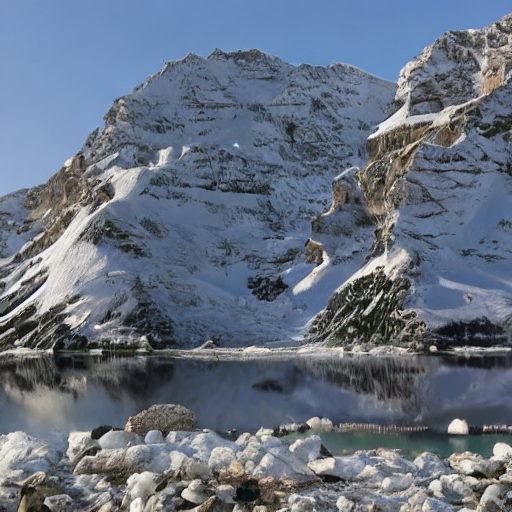

In [73]:
init_image

In [86]:
# !pip install fastdownload

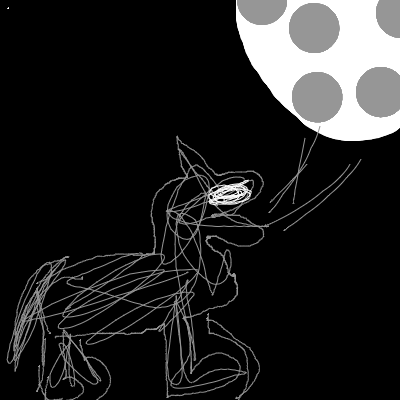

In [100]:
from fastdownload import FastDownload
p = FastDownload().download('https://s3.amazonaws.com/moonup/production/uploads/1664665907257-noauth.png')
init_image = PIL.Image.open(p).convert("RGB")
init_image

In [60]:
from diffusers import StableDiffusionImg2ImgPipeline

In [97]:
del img2img_pipe

In [98]:
# img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
#     model_id,
#     revision="fp16",
#     torch_dtype=torch.float16,
# ).to("cuda")



img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch.float16,
).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [103]:
device

device(type='cuda')

In [105]:
from torchvision import transforms

convert_tensor = transforms.ToTensor()

In [112]:
t = convert_tensor(init_image)
t = t[:, :320, :320]
t.shape

torch.Size([3, 320, 320])

In [113]:
t.dtype, t.device

(torch.float32, device(type='cpu'))

In [114]:
t = t.to(device)
t.device

device(type='cuda', index=0)

In [ ]:
img2img_pipe(prompt="blue sky", 
             init_image=t.half())

In [122]:
import random

219595089

In [ ]:
class Request(pydantic.BaseModel):
    prompt: str
    steps: int = 1
    guidance_scale: float = 7.5
    negative_prompt: str = None
    batch_size: int = 1
    seed: int = None
    mode: str = "txt2img"
    init_image: str = None
    strength: float = 0.8
        


async def txt2img(req: Request):
    print(req)
    tempdir = tempfile.gettempdir()
    local_dir = os.path.join(tempdir, "test.png")
    
    seed = req.seed if req.seed else random.randint(1, 1000000000)
    torch.manual_seed(seed)

    pipe_out = pipe(
        prompt=req.prompt, 
        num_inference_steps=req.steps,
        negative_prompt=req.negative_prompt,
    )
    print(pipe_out)
    images = pipe_out.images
    
    b64images = []
    for img in images:
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue())
        b64images.append(img_str.decode())
    return {
        'images': b64images,
        'seed': seed,
    }
    
#     image.save(local_dir)
#     return {'img_path': local_dir}

route_info = [{
    "path": "/",
    "method": "post",
    "endpoint": txt2img
}]

app = create_app(route_info)
serve(app)

t=2022-10-23T16:08:56+0000 lvl=warn msg="can't bind default web address, trying alternatives" obj=web addr=127.0.0.1:4040


http://0551-54-249-55-5.ngrok.io


INFO:     Started server process [28909]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


prompt='beautiful tokyo, cyberpunk' steps=50 guidance_scale=7.5 negative_prompt='city, street' batch_size=1 seed=68276560 mode='txt2img' init_image=None strength=0.8


  0%|          | 0/51 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F0D4B2B51D0>], nsfw_content_detected=[0])
INFO:     127.0.0.1:56458 - "POST / HTTP/1.1" 200 OK
prompt='beautiful tokyo, cyberpunk' steps=50 guidance_scale=7.5 negative_prompt='city, street night' batch_size=1 seed=68276560 mode='txt2img' init_image=None strength=0.8


  0%|          | 0/51 [00:00<?, ?it/s]

StableDiffusionPipelineOutput(images=[<PIL.Image.Image image mode=RGB size=512x512 at 0x7F0D4B2C0DD0>], nsfw_content_detected=[0])
INFO:     127.0.0.1:56484 - "POST / HTTP/1.1" 200 OK


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()